In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import logging
import torch.nn.functional as F
logging.basicConfig(level=logging.ERROR)


In [2]:
!pip install torchviz

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=ec5b42193ce7f2d895bf1a835a880056c5d6b3f6d43842b3b304b9429d4e68fa
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
from torchviz import make_dot

In [4]:
dataset = pd.read_csv('/kaggle/input/subtasks-dataset/0 CHIPSAL@COLING 2025/B/SubTask-B-train.csv', delimiter=',')
val_dataset_text = pd.read_csv('/kaggle/input/subtasks-dataset/0 CHIPSAL@COLING 2025/B/SubTask-B-(indextweet)val.csv', delimiter=',')
val_dataset_label = pd.read_csv('/kaggle/input/subtasks-dataset/0 CHIPSAL@COLING 2025/B/SubTask-B-(indexlabel)val.csv')
#test_dataset_text = pd.read_csv('/kaggle/input/subtasks-dataset/0 CHIPSAL@COLING 2025/B/Task-B(indextweet)val.csv', delimiter=',')
#test_dataset_label = pd.read_csv('/kaggle/input/subtasks-dataset/0 CHIPSAL@COLING 2025/B/Task-B(indexlabel)val.csv')

In [5]:
val_dataset = val_dataset_text.join(val_dataset_label['label'])
val_dataset

# test_dataset = test_dataset_text.join(test_dataset_label['label'])
# test_dataset


,index,tweet,label
0,10008,उत्तर प्रदेश विधानसभा सामान्य निर्वाचन-2022\n\...,0
1,10011,"सीएम केजरीवाल का ऐलान, सरकारी दफ्तरों में अम्ब...",0
2,10012,"जिनके घर शीशे के होते हैं, वो दूसरों पर पत्थर ...",1
3,10023,#बूथ_चैकिंग\n#CO_Sadar द्वारा आगामी #AssemblyE...,0
4,10029,#BastiPolice क्षेत्राधिकारी हरैया श्री शेषमणि ...,0
...,...,...,...
4071,37121,"सप्तरीमा कांग्रेस–एमाले कार्यकर्ताबीच झडप, पा...",0
4072,37122,"भाउजु लाई अब भर भजन किर्तन कै छ , जनताले भोट त...",0
4073,37123,काठमेयरको जम्मा भोटर 300223 जना 60% भोट खस्य...,0
4074,37149,"पतनको बाटोमा हिडेको कथित ""अनलाइन खबर"" र ""एमाले...",1


In [6]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
val_dataset

,index,tweet,label
0,10008,उत्तर प्रदेश विधानसभा सामान्य निर्वाचन-2022\n\...,0
1,10011,"सीएम केजरीवाल का ऐलान, सरकारी दफ्तरों में अम्ब...",0
2,10012,"जिनके घर शीशे के होते हैं, वो दूसरों पर पत्थर ...",1
3,10023,#बूथ_चैकिंग\n#CO_Sadar द्वारा आगामी #AssemblyE...,0
4,10029,#BastiPolice क्षेत्राधिकारी हरैया श्री शेषमणि ...,0
...,...,...,...
4071,37121,"सप्तरीमा कांग्रेस–एमाले कार्यकर्ताबीच झडप, पा...",0
4072,37122,"भाउजु लाई अब भर भजन किर्तन कै छ , जनताले भोट त...",0
4073,37123,काठमेयरको जम्मा भोटर 300223 जना 60% भोट खस्य...,0
4074,37149,"पतनको बाटोमा हिडेको कथित ""अनलाइन खबर"" र ""एमाले...",1


In [8]:
train = dataset[['tweet','label']]
val = val_dataset[['tweet','label']]
#test = test_dataset[['text','label']]

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, average_precision_score, roc_curve, precision_recall_curve

def calculate_metrics(df):
    # Extracting Predicted and True labels
    y_pred = df['Predicted']
    y_true = df['True']

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate precision, recall, F1-score for each class
    precision = precision_score(y_true, y_pred,average='weighted')
    recall = recall_score(y_true, y_pred,average='weighted')
    f1 = f1_score(y_true, y_pred,average='weighted')

    # Calculate micro-average precision, recall, F1-score
    micro_precision = precision_score(y_true, y_pred, average='micro')
    micro_recall = recall_score(y_true, y_pred, average='micro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')

    # Calculate macro-average precision, recall, F1-score
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
        
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Micro Precision:", micro_precision)
    print("Micro Recall:", micro_recall)
    print("Micro F1 Score:", micro_f1)
    print("Macro Precision:", macro_precision)
    print("Macro Recall:", macro_recall)
    print("Macro F1 Score:", macro_f1)

In [10]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = AutoTokenizer.from_pretrained("ibm/ia-multilingual-transliterated-roberta", truncation=True)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.tweet
        self.targets = self.data.label.astype(float)
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [12]:
val_data=val.copy()
train_data = train.copy()
# test_data = test.copy()


print("TRAIN Dataset: {}".format(train_data.shape))
print("VAL Dataset: {}".format(val_data.shape))
# print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
validation_set = SentimentData(val_data, tokenizer, MAX_LEN)
# stesting_set = SentimentData(stest_data, tokenizer, MAX_LEN)

TRAIN Dataset: (19019, 2)
VAL Dataset: (4076, 2)


In [13]:
val_data

,tweet,label
0,उत्तर प्रदेश विधानसभा सामान्य निर्वाचन-2022\n\...,0
1,"सीएम केजरीवाल का ऐलान, सरकारी दफ्तरों में अम्ब...",0
2,"जिनके घर शीशे के होते हैं, वो दूसरों पर पत्थर ...",1
3,#बूथ_चैकिंग\n#CO_Sadar द्वारा आगामी #AssemblyE...,0
4,#BastiPolice क्षेत्राधिकारी हरैया श्री शेषमणि ...,0
...,...,...
4071,"सप्तरीमा कांग्रेस–एमाले कार्यकर्ताबीच झडप, पा...",0
4072,"भाउजु लाई अब भर भजन किर्तन कै छ , जनताले भोट त...",0
4073,काठमेयरको जम्मा भोटर 300223 जना 60% भोट खस्य...,0
4074,"पतनको बाटोमा हिडेको कथित ""अनलाइन खबर"" र ""एमाले...",1


In [14]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }
# test_params = {'batch_size': VALID_BATCH_SIZE,
#                 'shuffle': False,
#                 'num_workers': 0
#                 }
training_loader = DataLoader(training_set, **train_params)
validating_loader = DataLoader(validation_set, **val_params)
#stesting_loader = DataLoader(stesting_set, **test_params)

In [15]:
class MultilingualRobertaClass(torch.nn.Module):
    def __init__(self):
        super(MultilingualRobertaClass, self).__init__()
        self.l1 = AutoModel.from_pretrained("ibm/ia-multilingual-transliterated-roberta")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = torch.nn.Sigmoid()(output)
        return output

In [16]:
model = MultilingualRobertaClass()
model.to(device)

pytorch_model.bin:   0%|          | 0.00/685M [00:00<?, ?B/s]

MultilingualRobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(110000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

In [17]:
# Creating the loss function and optimizer
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [18]:
# def calcuate_accuracy(preds, targets):
#     n_correct = (preds==targets).sum().item()
#     return n_correct

def calcuate_accuracy(preds, targets):
    # Convert predictions to binary values (0 or 1)
    preds_binary = (preds > 0.5).float()
    # Calculate the number of correct predictions
    n_correct = (preds_binary == targets.view(-1, 1)).sum().item()  # Reshape targets to match the shape of preds_binary
    
    return n_correct

In [19]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        targetss = targets.view(-1, 1)
        loss = loss_function(outputs.float(), targetss.float())
        tr_loss += loss.item()
        correct_batch = calcuate_accuracy(outputs, targets)
        n_correct += correct_batch

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return outputs, model

In [20]:
def valid(model, testing_loader, epoch):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    res_p_l=[]
    res_pb_l=[]
    res_t_l=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            targetss = targets.view(-1, 1)
            outputss = outputs.view(-1, 1)
            loss = loss = loss_function(outputss.float(), targetss.float())
            tr_loss += loss.item()
            
            correct_batch = calcuate_accuracy(outputs, targets)
            
            n_correct += correct_batch
            
            preds_binary = (outputs > 0.5).float()
            
            
            res_p_l.append(outputss.cpu().tolist())
            res_pb_l.append(preds_binary.cpu().tolist())
            res_t_l.append(targetss.cpu().tolist())

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    predicted_all  = [item[0] for sublist in res_p_l for item in sublist]
    predicted_b_all  = [item[0] for sublist in res_pb_l for item in sublist]
    true_all = [item[0] for sublist in res_t_l for item in sublist]
    
    df_sub=pd.DataFrame({'Predicted':predicted_b_all,'Predicted Prob':predicted_all, 'True':true_all})
    df_sub.to_csv("Outputs"+str(epoch)+".csv",index=False)
    
    calculate_metrics(df_sub)
    
    return epoch_accu

In [21]:
def test(model, stesting_loader, epoch):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    res_p_l=[]
    res_pb_l=[]
    res_t_l=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(stesting_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            targetss = targets.view(-1, 1)
            outputss = outputs.view(-1, 1)
            loss = loss = loss_function(outputss.float(), targetss.float())
            tr_loss += loss.item()
            
            correct_batch = calcuate_accuracy(outputs, targets)
            
            n_correct += correct_batch
            
            preds_binary = (outputs > 0.5).float()
            
            
            res_p_l.append(outputss.cpu().tolist())
            res_pb_l.append(preds_binary.cpu().tolist())
            res_t_l.append(targetss.cpu().tolist())

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Test Loss Epoch: {epoch_loss}")
    print(f"Test Accuracy Epoch: {epoch_accu}")
    
    predicted_all  = [item[0] for sublist in res_p_l for item in sublist]
    predicted_b_all  = [item[0] for sublist in res_pb_l for item in sublist]
    true_all = [item[0] for sublist in res_t_l for item in sublist]
    
    df_sub=pd.DataFrame({'Predicted':predicted_b_all,'Predicted Prob':predicted_all})
    df_sub.to_csv("Outputs_test_"+str(epoch)+".csv",index=False)
    
    #calculate_metrics(df_sub)
    
    return epoch_accu

In [22]:
def save_model(epoch):
    output_model_file = '/kaggle/working/pytorch_IBM_multilingual_roberta_'+str(epoch)+'_taskB.bin'
    output_vocab_file = './'

    model_to_save = model
    torch.save(model_to_save, output_model_file)

In [23]:
EPOCHS = 5
for epoch in range(1,EPOCHS+1):
    print ("==============================\nEpoch: ",epoch,"\n===========================")
    y,model = train(epoch)
    valid(model, validating_loader, epoch)
    #test(model, stesting_loader, epoch)
    #save_model(epoch)
    make_dot(y.mean(), params=dict(model.named_parameters()))

Epoch:  1 


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.7078699469566345
Training Accuracy per 5000 steps: 37.5


2378it [08:19,  4.76it/s]


The Total Accuracy for Epoch 1: 88.40633051159367
Training Loss Epoch: 0.29095270992526934
Training Accuracy Epoch: 88.40633051159367


1019it [00:37, 26.88it/s]


Validation Loss Epoch: 0.25950028467237934
Validation Accuracy Epoch: 88.98429833169774
Accuracy: 0.8898429833169774
Precision: 0.8697003919375713
Recall: 0.8898429833169774
F1 Score: 0.8510077482269143
Micro Precision: 0.8898429833169774
Micro Recall: 0.8898429833169774
Micro F1 Score: 0.8898429833169775
Macro Precision: 0.7926759104769576
Macro Recall: 0.5446921190056158
Macro F1 Score: 0.553998908711712
Epoch:  2 


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.12270264327526093
Training Accuracy per 5000 steps: 87.5


2378it [08:19,  4.76it/s]


The Total Accuracy for Epoch 2: 90.21504810978495
Training Loss Epoch: 0.22500415012301897
Training Accuracy Epoch: 90.21504810978495


1019it [00:37, 26.85it/s]


Validation Loss Epoch: 0.2757030559467907
Validation Accuracy Epoch: 89.1315014720314
Accuracy: 0.891315014720314
Precision: 0.871576115555389
Recall: 0.891315014720314
F1 Score: 0.8754955637757575
Micro Precision: 0.891315014720314
Micro Recall: 0.891315014720314
Micro F1 Score: 0.891315014720314
Macro Precision: 0.7379326597374544
Macro Recall: 0.6298007201812401
Macro F1 Score: 0.6612823925438412
Epoch:  3 


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.026381688192486763
Training Accuracy per 5000 steps: 100.0


2378it [08:19,  4.76it/s]


The Total Accuracy for Epoch 3: 93.8798044061202
Training Loss Epoch: 0.1532938050845782
Training Accuracy Epoch: 93.8798044061202


1019it [00:38, 26.74it/s]


Validation Loss Epoch: 0.3497401801997227
Validation Accuracy Epoch: 88.8125613346418
Accuracy: 0.888125613346418
Precision: 0.8620385501589495
Recall: 0.888125613346418
F1 Score: 0.8639853836124802
Micro Precision: 0.888125613346418
Micro Recall: 0.888125613346418
Micro F1 Score: 0.888125613346418
Macro Precision: 0.7278274750760519
Macro Recall: 0.5886064235293567
Macro F1 Score: 0.6155951250343319
Epoch:  4 


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.23687273263931274
Training Accuracy per 5000 steps: 87.5


2378it [08:19,  4.76it/s]


The Total Accuracy for Epoch 4: 96.82422840317577
Training Loss Epoch: 0.08978879865838757
Training Accuracy Epoch: 96.82422840317577


1019it [00:37, 26.88it/s]


Validation Loss Epoch: 0.4120798670461491
Validation Accuracy Epoch: 88.12561334641806
Accuracy: 0.8812561334641805
Precision: 0.8695510785902449
Recall: 0.8812561334641805
F1 Score: 0.8743556146985988
Micro Precision: 0.8812561334641805
Micro Recall: 0.8812561334641805
Micro F1 Score: 0.8812561334641805
Macro Precision: 0.7031264802008337
Macro Recall: 0.6607510595379501
Macro F1 Score: 0.6781299538009623
Epoch:  5 


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 0.02395467646420002
Training Accuracy per 5000 steps: 100.0


2378it [08:19,  4.76it/s]


The Total Accuracy for Epoch 5: 98.09664020190336
Training Loss Epoch: 0.058234535364320154
Training Accuracy Epoch: 98.09664020190336


1019it [00:37, 26.82it/s]


Validation Loss Epoch: 0.44490196479623134
Validation Accuracy Epoch: 88.24828263002944
Accuracy: 0.8824828263002944
Precision: 0.8690078685942013
Recall: 0.8824828263002944
F1 Score: 0.8742614747334562
Micro Precision: 0.8824828263002944
Micro Recall: 0.8824828263002944
Micro F1 Score: 0.8824828263002944
Macro Precision: 0.7056370635373816
Macro Recall: 0.6550328345480828
Macro F1 Score: 0.6749096320895038


In [24]:
save_model(EPOCHS)

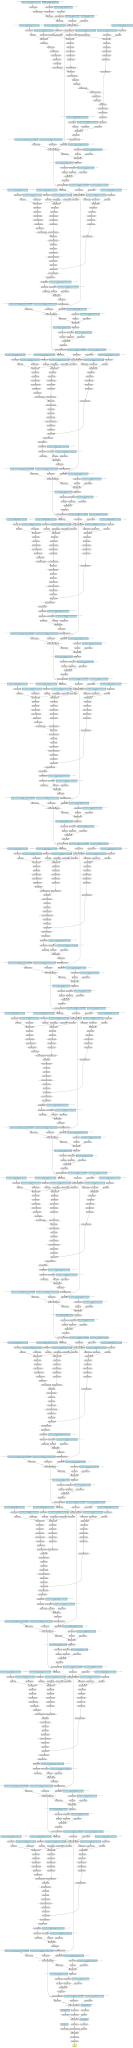

In [25]:
make_dot(y.mean(), params=dict(model.named_parameters()))

In [26]:
tokenizer.save_vocabulary('./')

('./vocab.json', './merges.txt')